# Experiments with choice of radius for embedding 100,000 model spectra

Here, I find the optimal radius for subsets of the model set divided into quartiles of mean stellar age. I also repeat embeddings done previously but using different radii for the neighbors search and for the similarity calculation.

Authored by OGT 17-11-15

In [1]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
%matplotlib inline
from astroML.plotting import setup_text_plots
import h5py
import fsps
import math

from megaman.geometry import Geometry
from megaman.embedding import SpectralEmbedding
from scipy.io import mmwrite
from scipy.sparse.csgraph import connected_components
from sklearn.metrics.pairwise import euclidean_distances

np.set_printoptions(suppress=True)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('xtick.major', width=2)
mpl.rc('ytick.major', width=2)
mpl.rc('axes', labelsize=18, linewidth=2, titlesize=18)
mpl.rc('figure', titlesize=18)
mpl.rc('lines', linewidth=3)
mpl.rc('legend', fontsize=16)

In [2]:
# load data

f = h5py.File('../data/1e5_spectra_diverseSFH_17-02-07.hdf5','r')
spectra = f['spectra'][:]  # 100,000 model galaxy spectra
wave = f['wave'][:]  # the wavelengths at which the spectra are sampled, 4220 points each
taus = f['taus'][:]  # the exponential decay timescale that characterizes the star formation histories (SFHs)
mean_ages = f['mean_ages'][:]  # the mean stellar age that I calculated for each SFH
zs = f['zs'][:]  # the "metallicity" or metal content of the stellar population
dusts = f['dusts'][:]  # the amount of dust present in the galaxy
sdss_mags = f['sdss_mags'][:]  # the brightness of the spectrum in 5 different "filters" or wavelength regions
fbursts = f['fbursts'][:]  # the fraction of stars in a galaxy formed in an instantaneous burst of star formation
tbursts = f['tbursts'][:]  # the time after the Big Bang (t=0) when that burst of star formation occurred
sf_begins = f['sf_begins'][:]  # the time after the Big Bang when the exponentially-declining SFH begins (no SF before)
f.close()

In [49]:
def plot_vsdim_cc(ndim, yparam, ccparam, ylabel, cblabel, use_embed, limits=None):
    if ndim > 10:
        nrows = int(math.ceil(ndim / 5))
        ncols = int(math.ceil(ndim / nrows))
        fig, ax = plt.subplots(nrows, ncols, figsize=(15,15))
    else:
        nrows = 2
        ncols = ndim / 2
        fig, ax = plt.subplots(nrows, ncols, figsize=(15,8))
    ax = ax.ravel()
    for ii in range(ndim):
        im = ax[ii].scatter(use_embed[:,ii], yparam, c=ccparam, s=5, lw=0, cmap='viridis')
        ax[ii].set_xlabel('Dimension {}'.format(ii))
        if limits is not None:
            ax[ii].set_xlim(limits[0])
            ax[ii].set_ylim(limits[1])
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(cblabel)
    ax[0].set_ylabel(ylabel)
    ax[ndim/2].set_ylabel(ylabel)
    plt.draw()
    fig.subplots_adjust(right=0.85, top=0.9)

## Split sample into quartiles of mean stellar age and do the distance matrix calculation for different chunks - start with old spectra first, since we know these behave in a sensible way

In [4]:
age_q1 = np.where(mean_ages < np.percentile(mean_ages, 25))
age_q2 = np.where((mean_ages > np.percentile(mean_ages, 25)) * (mean_ages <= np.percentile(mean_ages, 50)))
age_q3 = np.where((mean_ages > np.percentile(mean_ages, 50)) * (mean_ages <= np.percentile(mean_ages, 75)))
age_q4 = np.where(mean_ages >= np.percentile(mean_ages, 75))
print np.min(mean_ages), np.max(mean_ages)
print np.min(mean_ages[age_q1]), np.max(mean_ages[age_q1])
print np.min(mean_ages[age_q2]), np.max(mean_ages[age_q2])
print np.min(mean_ages[age_q3]), np.max(mean_ages[age_q3])
print np.min(mean_ages[age_q4]), np.max(mean_ages[age_q4])

0.556538728751 13.3756404563
0.556538728751 6.59881437313
6.59890385102 8.49269751483
8.49273505121 10.8281594796
10.8281670178 13.3756404563


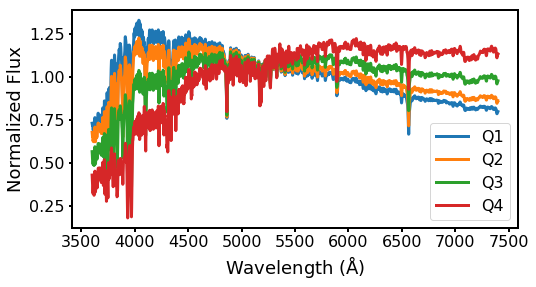

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
quartile = 1
for inds in [age_q1, age_q2, age_q3, age_q4]:
    ax.plot(wave, np.mean(spectra[inds[0]], axis=0), label='Q{}'.format(quartile))
    quartile += 1
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)')
ax.set_ylabel('Normalized Flux')
plt.legend()

In [13]:
youngspectra = spectra[age_q1[0],:][:10000,:]
youngages = mean_ages[age_q1[0]][:10000]
youngzs = zs[age_q1[0]][:10000]
youngdusts = dusts[age_q1[0]][:10000]
print np.shape(youngspectra), np.mean(mean_ages[age_q1])

(10000, 4220) 4.2230423956


In [ ]:
# from megaman.utils import estimate_radius as er

# radius = 10.0  # just choosing a big radius to start
# adjacency_method = 'cyflann'
# cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
# adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
# affinity_method = 'gaussian'
# affinity_kwds = {'radius':radius}

# geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
#                 affinity_method=affinity_method, affinity_kwds=affinity_kwds)
# geom.set_data_matrix(oldspectra)
# adjacency_matrix = geom.compute_adjacency_matrix()

# testinds = np.random.randint(0, 10000, 500)
# # data, distance matrix up to rmax, indices of test subset, dim, rmin, rmax, nsteps, run parallel?
# results = er.run_estimate_radius(oldspectra, adjacency_matrix, 
#                                  testinds, 4, 0.1, 10, 20, False)

performing radius search...



/Users/Grace/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


for radius: 0.1 distortion is: 1.84967460652
for radius: 0.1 analysis took: 1151.15174603 seconds



# Using new estimate of best radius to attempt embedding the oldest quartile

From the above code that is commented out, I get that the best radius is 0.72, which is very close to the $\log(r_{best}) = -0.17$ that I found using the fit to the log-log plot. Will try using the following values:
* affinity: $r_{aff} = \frac{\sqrt2}{3} r_{best} = 0.34$
* adjacency: $r_{adj} = 5 r_{aff} = 1.70$

In [7]:
r_best = 0.72
r_aff = r_best * np.sqrt(2.) / 3.
r_adj = 5 * r_aff

adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':r_adj, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':r_aff}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(oldspectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
# new_radius = np.max(adjacency_matrix.data)
# print new_radius
# omitting the above lines and replacing "new_radius" with "r_aff" in below code

affinity_kwds = {'radius': r_aff}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps': r_aff}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

1 components
10000 spectra in first component


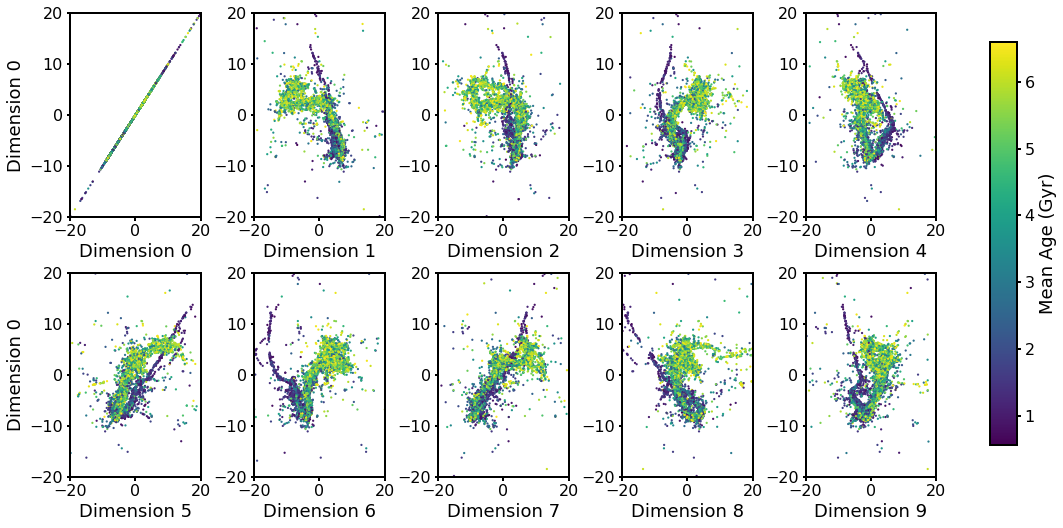

In [101]:
plot_vsdim_cc(ndim, use_embed[:,0], youngages, ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed, limits=[[-20, 20], [-20, 20]])
plt.savefig('embed_youngspectra_alldims.png')

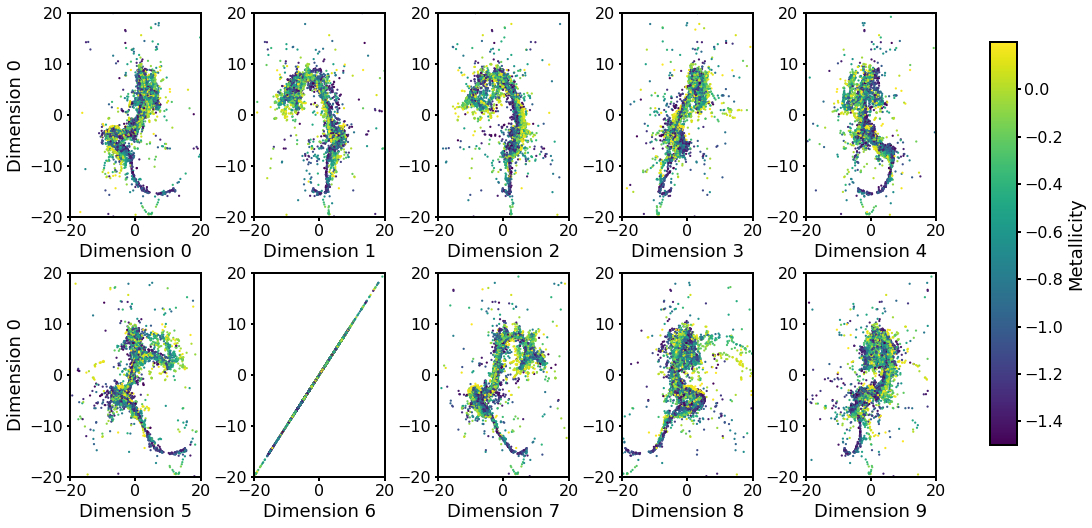

In [97]:
plot_vsdim_cc(ndim, use_embed[:,6], youngzs, ylabel='Dimension 0', cblabel='Metallicity',
              use_embed=use_embed, limits=[[-20, 20], [-20, 20]])

In [72]:
"""This and cell below copied from trident_arms.ipynb in the embedsdss project"""
def add_subplot_axes(ax,rect): #,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height]) #,axisbg=axisbg)
    subax.patch.set_alpha(0.3)
    subax.get_xaxis().set_visible(False)
    subax.get_yaxis().set_visible(False)
    #x_labelsize = subax.get_xticklabels()[0].get_size()
    #y_labelsize = subax.get_yticklabels()[0].get_size()
    #x_labelsize *= rect[2]**0.5
    #y_labelsize *= rect[3]**0.5
    #subax.xaxis.set_tick_params(labelsize=x_labelsize)
    #subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax
 
def change_coordinates(ax, pos):
    # want to go from coordinates in subplot to [0,1] coordinates
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    subpos = []
    subpos.append((pos[0]-xlim[0]) / (xlim[1]-xlim[0]))
    subpos.append((pos[1]-ylim[0]) / (ylim[1]-ylim[0]))
    subpos.append(pos[2] / (xlim[1]-xlim[0]))
    subpos.append(pos[3] / (ylim[1]-ylim[0]))
    return subpos

In [116]:
def get_mean_spectrum(xlow, ylow, width, xdim=1, ydim=2, pc=use_embed, usespectra=youngspectra):
    use = (pc[:,xdim] > xlow) * (pc[:,xdim] < xlow + width) * (pc[:,ydim] > ylow) * (pc[:,ydim] < ylow + width)
    if np.sum(use) < 10:
        stack = np.zeros(usespectra.shape[1])
        p16 = np.zeros(usespectra.shape[1])
        p84 = np.zeros(usespectra.shape[1])

    else:
        boxspectra = usespectra[use, :]
        stack = np.mean(boxspectra, axis=0)
        p16 = np.percentile(boxspectra, 2.5, axis=0)
        p84 = np.percentile(boxspectra, 97.5, axis=0)
    return stack, p16, p84

def overplot_spectra_grid(pc=use_embed, colorparam=youngages, cblabel='Mean Ages', xdim=0, ydim=1,
                          lims=[[-15,15], [-15,10]], width=2, usespectra=youngspectra):
    fig, ax = plt.subplots(figsize=(12,10))
    ax0 = ax.scatter(use_embed[:,xdim], use_embed[:,ydim], c=colorparam, s=10)
    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
    ax.set_xlabel('Dimension {}'.format(xdim))
    ax.set_ylabel('Dimension {}'.format(ydim))
    cb = plt.colorbar(ax0, ax=ax, label=cblabel)
    
    xs = np.arange(lims[0][0], lims[0][1], width)
    ys = np.arange(lims[1][0], lims[1][1], width)
    
    for ii in range(len(xs)):
        for jj in range(len(ys)):
            pos = [xs[ii], ys[jj], width, width]
            stack, p16, p84 = get_mean_spectrum(xs[ii], ys[jj], width, pc=pc, xdim=xdim, ydim=ydim, usespectra=youngspectra)
            if np.sum(stack) == 0:
                continue
            else:
                subpos = change_coordinates(ax, pos)
                subax = add_subplot_axes(ax, subpos)
                subax.fill_between(wave, p16, p84, facecolor='C0')
                subax.plot(wave, stack, 'k-', lw=1)                
    return ax

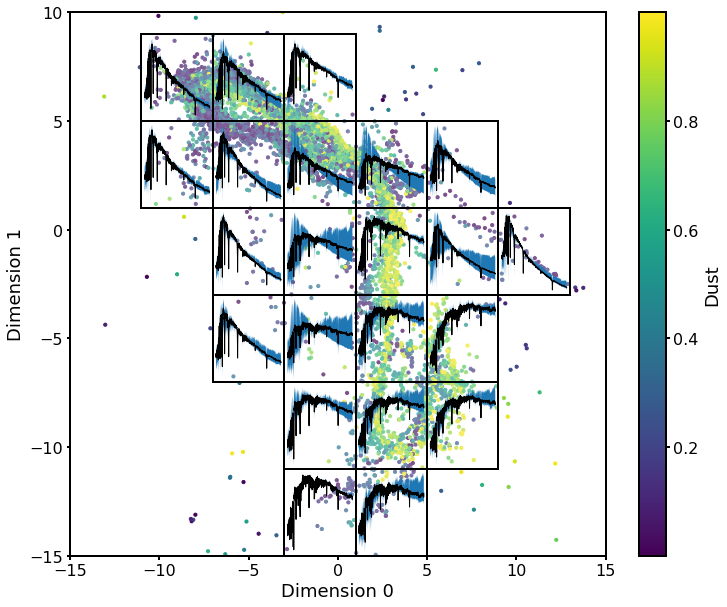

In [120]:
overplot_spectra_grid(width=4, colorparam=youngdusts, cblabel='Dust')
plt.savefig('newembed_meanspec_dust.png')

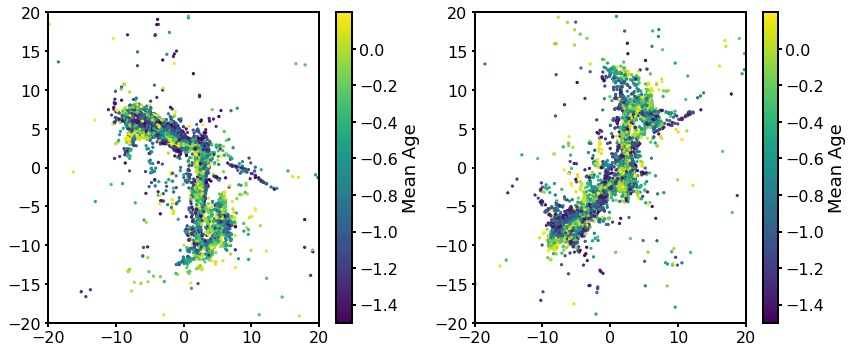

In [67]:
limits = [[-20, 20], [-20, 20]]
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax0 = ax[0].scatter(use_embed[:,0], use_embed[:,1], c=youngzs, s=5)
ax[0].set_xlim(-20,20)
ax[0].set_ylim(-20,20)
cb = plt.colorbar(ax0, ax=ax[0], label='Mean Age')
ax1 = ax[1].scatter(use_embed[:,0], use_embed[:,7], c=youngzs, s=5)
ax[1].set_xlim(limits[0])
ax[1].set_ylim(limits[1])
cb = plt.colorbar(ax1, ax=ax[1], label='Mean Age')
plt.tight_layout()

### Now try using a radius for the Laplacian that is 1/5 of the maximum radius in the adjacency matrix

In [112]:
radius = 10**0.13
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius*5, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius*5}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
# new_radius = np.max(adjacency_matrix.data)
# print 'Neighborhood radius={}, Laplacian radius={}'.format(radius, new_radius/5.)

affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

1 components
10000 spectra in first component


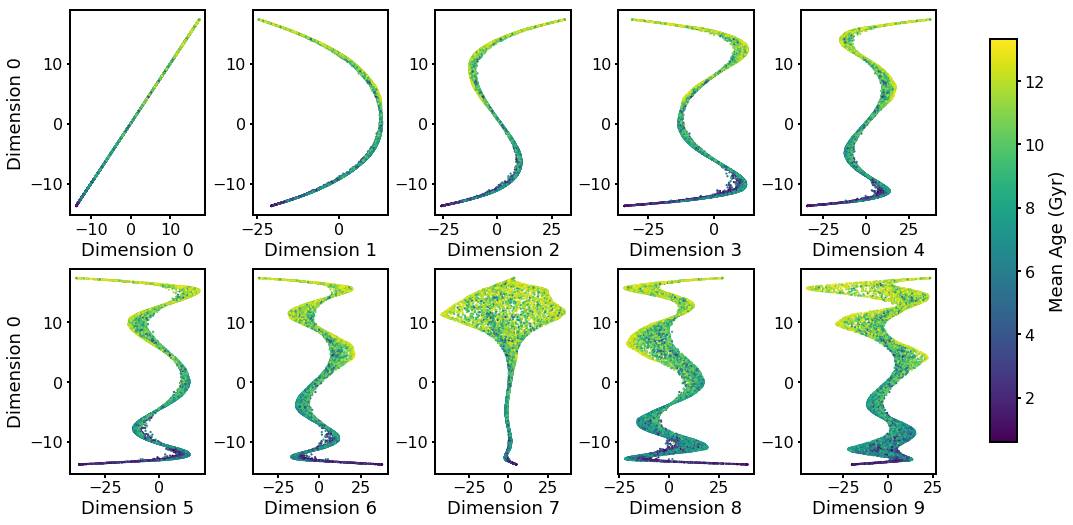

In [113]:
plot_vsdim_cc(ndim, use_embed[:,0], mean_ages[:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

## This did not change things. Huh. Let's try using different radii where we start with log(r)=0.5

In [32]:
radius = 10**0.5
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print new_radius

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

3.16223
1 components
10000 spectra in first component


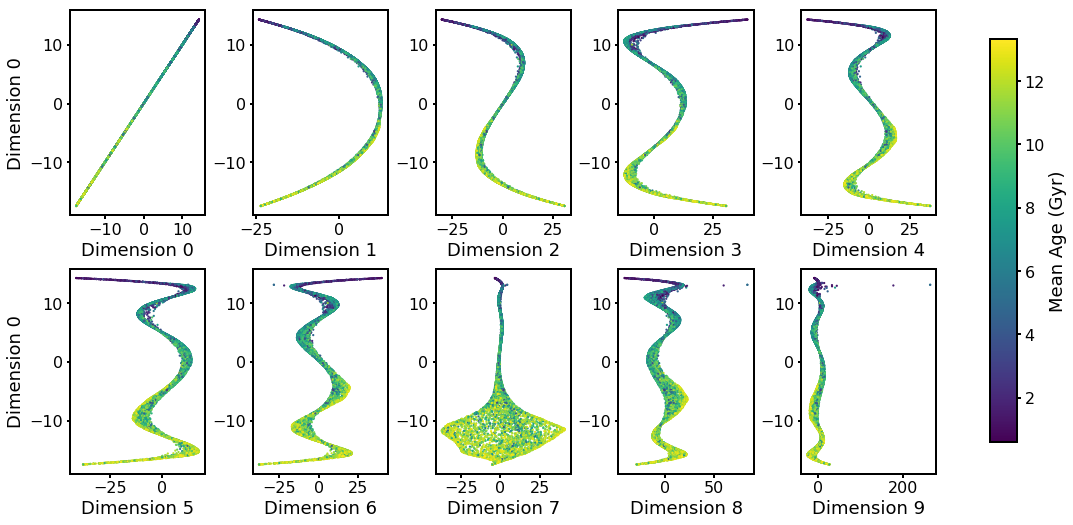

In [33]:
plot_vsdim_cc(ndim, use_embed[:,0], mean_ages[:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

### Now try using a radius for the Laplacian that is 1/5 of the maximum radius in the adjacency matrix

In [61]:
radius = 10**0.5
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print 'Neighborhood radius={}, Laplacian radius={}'.format(radius, new_radius/5.)

affinity_kwds = {'radius':new_radius/5.}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius/5.}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

Neighborhood radius=3.16227766017, Laplacian radius=0.632445383072
1 components
10000 spectra in first component


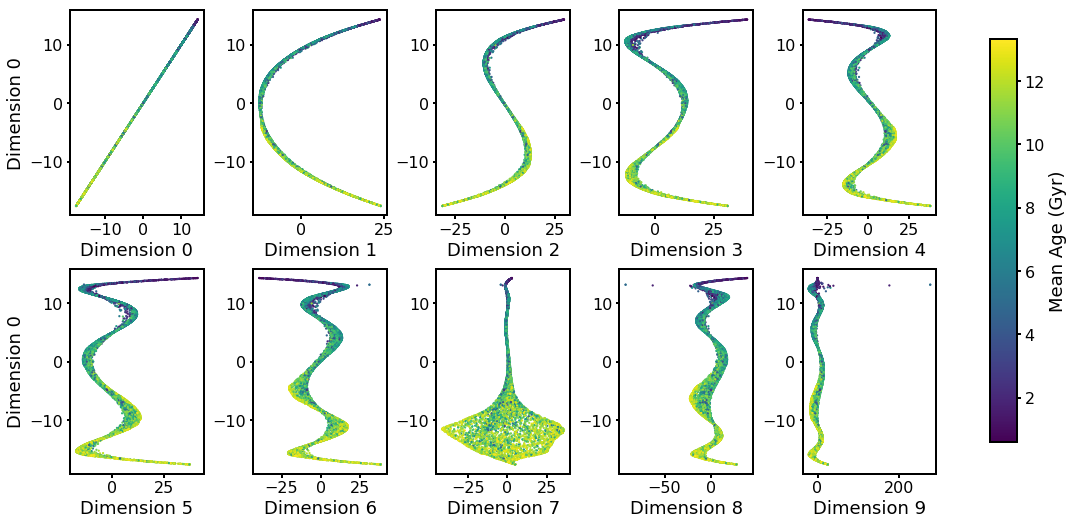

In [62]:
plot_vsdim_cc(ndim, use_embed[:,0], mean_ages[:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

# Now try embeddings for old spectra only, then young

In [66]:
radius = 10**0.5 #-0.09 -- "optimal" radius gave similar junk to "optimal" for full dataset
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

inds = age_q4[0]
geom.set_data_matrix(spectra[inds,:][:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print 'Neighborhood radius={}, Laplacian radius={}'.format(radius, new_radius/5.)

affinity_kwds = {'radius':new_radius/5.}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius/5.}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

Neighborhood radius=3.16227766017, Laplacian radius=0.632225227356
1 components
10000 spectra in first component


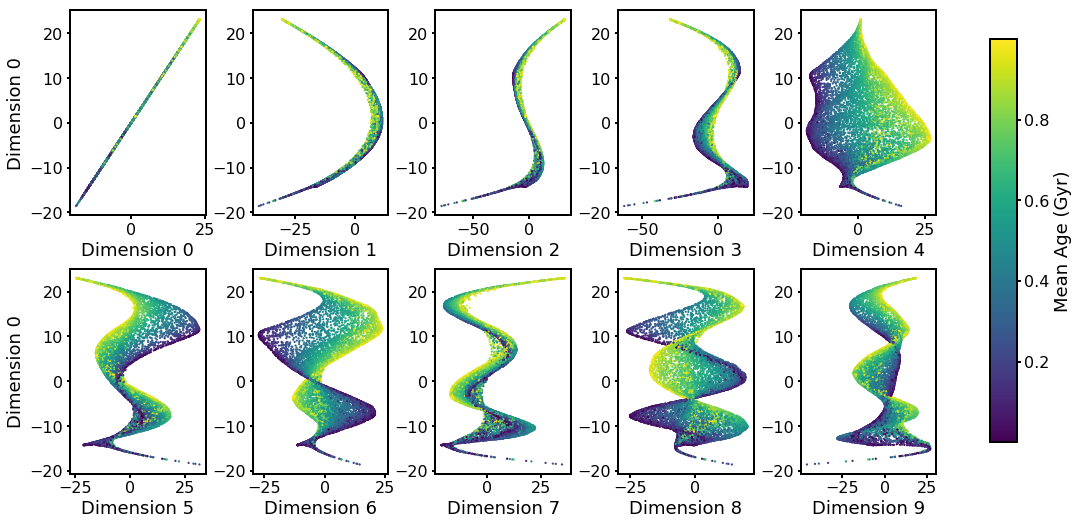

In [70]:
plot_vsdim_cc(ndim, use_embed[:,0], dusts[inds][:10000][wh], ylabel='Dimension 0', cblabel='Dust'

In [114]:
radius = 10**0.5 #-0.09 -- "optimal" radius gave similar junk to "optimal" for full dataset
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

inds = age_q1[0]
geom.set_data_matrix(spectra[inds,:][:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

# update radius -- unclear why... 
new_radius = np.max(adjacency_matrix.data)
print 'Neighborhood radius={}, Laplacian radius={}'.format(radius, new_radius/5.)

affinity_kwds = {'radius':new_radius/5.}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius/5.}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

ndim=10
spectral = SpectralEmbedding(n_components=ndim, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'
wh = labels == 0
use_embed = embed[wh,:] * 1000

Neighborhood radius=3.16227766017, Laplacian radius=0.6323366642
1 components
10000 spectra in first component


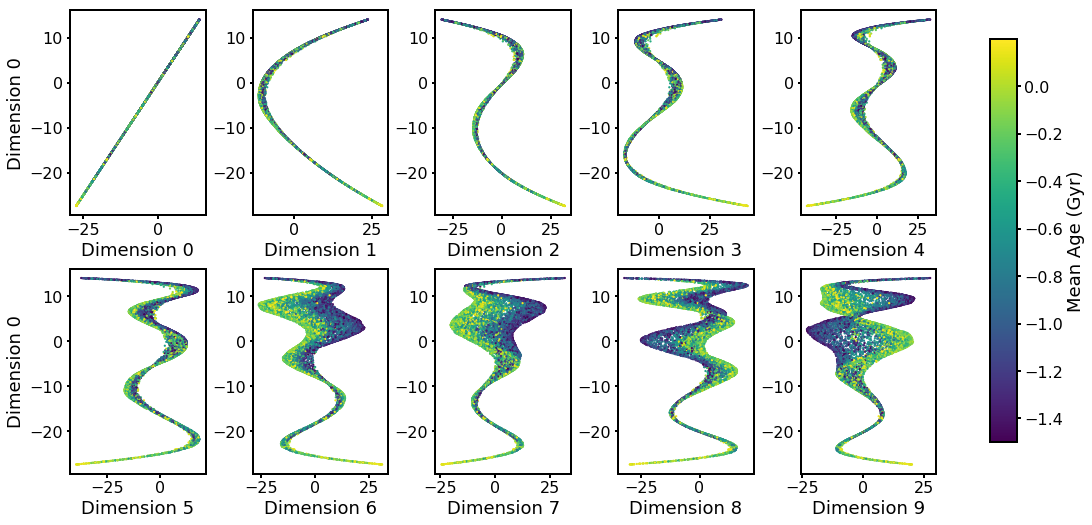

In [134]:
plot_vsdim_cc(ndim, use_embed[:,0], zs[inds][:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

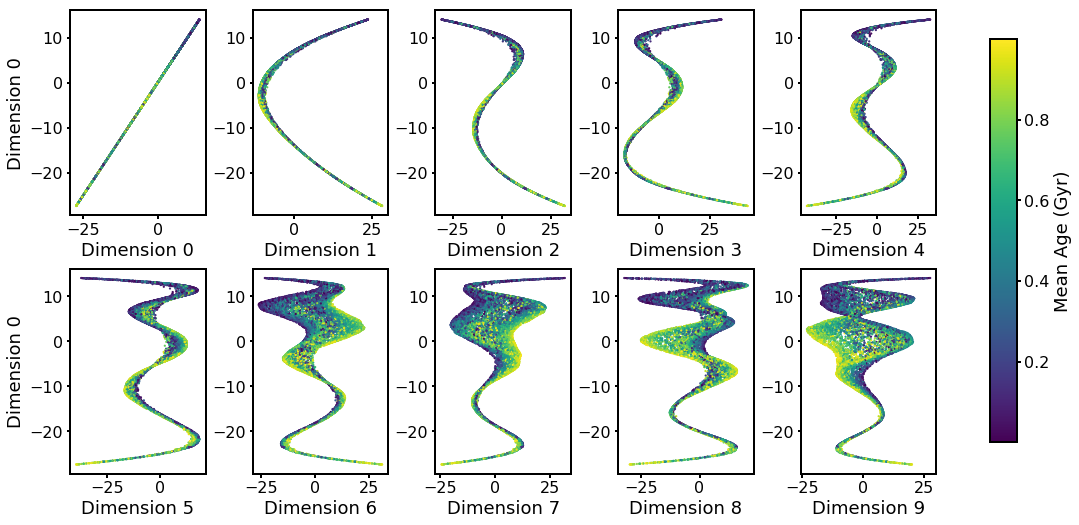

In [135]:
plot_vsdim_cc(ndim, use_embed[:,0], dusts[inds][:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

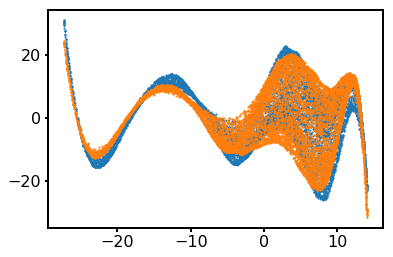

In [141]:
plt.figure()
plt.scatter(use_embed[:,0], use_embed[:,6], s=1)
plt.scatter(use_embed[:,0], -use_embed[:,7], s=1)

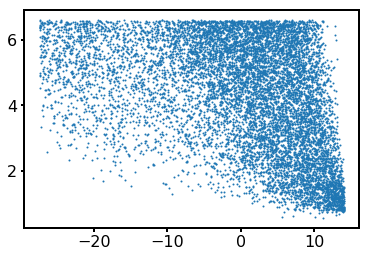

In [143]:
plt.figure()
plt.scatter(use_embed[:,0], mean_ages[inds][:10000], s=1)

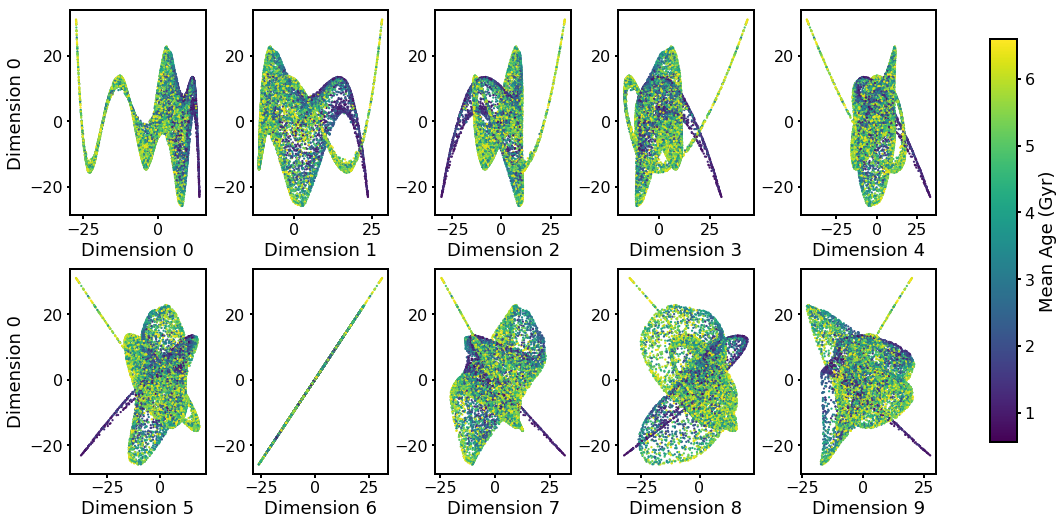

In [116]:
plot_vsdim_cc(ndim, use_embed[:,6], mean_ages[inds][:10000][wh], ylabel='Dimension 0', cblabel='Mean Age (Gyr)',
              use_embed=use_embed)

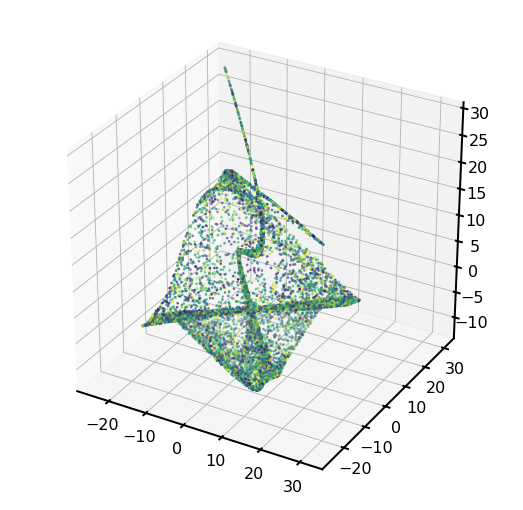

In [140]:
# plt.figure(figsize=(9,9))
# plt.scatter(use_embed[:,7], use_embed[:,6], c=mean_ages[:10000], s=3)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(use_embed[:,7], use_embed[:,6], zs=use_embed[:,1], c=zs[:10000], s=3)

## Now try running the estimate_radius code in megaman

In [74]:
# this is for the young spectra in the previous embedding attempt

from megaman.utils import estimate_radius as er
test = er.run_estimate_radius(spectra[inds,:][:10000,:], adjacency_matrix, np.arange(500).tolist(), 4, 0.1, 10.0, 20, 
                              False, search_space='logspace')

ImportError: cannot import name estimate_radius